In [1]:
"""  
此文件用于获取 developing disturbance data 和 non-developing disturbance data

注意：    所拿到的场的数据要比想要的场数据大8圈 

"""


'  \n此文件用于获取 developing disturbance data 和 non-developing disturbance data\n'

In [2]:
import xarray  as xr
import numpy as np
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import matplotlib.pyplot as plt   
from matplotlib import colormaps
from typing import Tuple , Any, List
from numpy.typing import NDArray 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.patches import Rectangle
from scipy import ndimage


# 数据处理和绘图class 

In [183]:
"""  获取数据类  """
class getInitData( object):
    def __init__(self, init_data_pth):
        self.init_data_pth = init_data_pth

    # 获取原始数据
    def get_init_data(self)-> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.datetime64]:
        init_data =  xr.open_dataset(self.init_data_pth)
        # 获取每隔6小时的数据 (原始数据间隔为1小时)，  经纬度在下载的时候已经确定  
        interval = 6 
        init_data = init_data.sel(valid_time=init_data.valid_time.values[::6])
        u = init_data.u.values
        v = init_data.v.values
        vo = init_data.vo.values   # 涡度
        lons = init_data.longitude.values
        lats = init_data.latitude.values
        timeOfSpecific = init_data.valid_time.values
        return u,v, vo , lons , lats , timeOfSpecific

    #  2D smth9 for (lat, lon) (转写自ncl) 
    def smth9_2d(self, data: np.ndarray, 
                 p=0.5, q=0.25) -> np.ndarray:
        kernel = np.array([
            [p / 4, q / 4, p / 4],
            [q / 4, 1 - p - q, q / 4],
            [p / 4, q / 4, p / 4]
        ])
        smoothed = ndimage.convolve(data, kernel, mode='constant', cval=0.0)
        return smoothed

# 关于风的处理
class WindRelated(object):
    def __init__(self, u: np.ndarray, v: np.ndarray, lons: np.ndarray, lats: np.ndarray):
        self.u = u
        self.v = v
        self.lons = lons
        self.lats = lats

    # 气旋性环流判断
    def cyclone_circulation(self) -> NDArray[np.float_]:
        u, v = self.u, self.v
        ny, nx = u.shape

        # 除了最外面一圈的内部的数据
        v_north = v[:-2, 1:-1]    # i-1, j
        v_south = v[2:, 1:-1]     # i+1, j
        u_east  = u[1:-1, 2:]     # i, j+1
        u_west  = u[1:-1, :-2]    # i, j-1

        # 中心区域 (1:-1, 1:-1), 由于指定dtype, 所以正确的返回  1 ， 不正确保持0不变。 
        center = np.zeros((ny, nx) , dtype=np.float_)
        # center[1:-1, 1:-1] = (
        #     (v_north > 0) & 
        #     (v_south < 0) & 
        #     (u_east < 0) & 
        #     (u_west > 0)
        # ).astype(np.float_)

      # 对于区域内部的每个点进行循环
        for i in range(1, ny - 1):
            for j in range(1, nx - 1):
                # 获取上下左右的速度分量
                uOfsouth = u[i-1, j]   # 上方
                uOfnorth = u[i+1, j]   # 下方
                vOfeast = v[i, j+1]    # 右侧
                vOfwest = v[i, j-1]    # 左侧

                # 判断是否形成逆时针气旋环流
                if (uOfsouth > 0) and (uOfnorth < 0) and (vOfwest < 0) and (vOfeast > 0):
                    center[i, j] = 1.0  # 符合条件标记为1
        return center

     # 风速计算
    @staticmethod
    def wind_speed(u:np.ndarray, v:np.ndarray):
        return np.sqrt(u ** 2 + v ** 2)


""" 绘图类  """
class DrawImg( object):
    def __init__(self, 
                 lons: np.ndarray,
                 lats: np.ndarray, 
                 specific_times: np.datetime64,
                 variable: tuple,    # (u, v, vo , .....)
                 save_img_pth: str, 
                 ):

        self.lons = lons
        self.lats = lats
        self.specific_times = specific_times
        self.u = variable[0]
        self.v = variable[1]
        self.vo = variable[2]
        self.save_img_pth = save_img_pth

    def draw_img(self, dist_center_list: List[List[Tuple[Any, Any,]]  ] = None,
                 test_list: List[List[Tuple[Any, Any,]]  ] = None,
                 ):

        wOfBox, hOfBox = 8,8

        # === 第一步：统一 colorbar 的范围 ===
        # 找出所有 vo 数据的全局最小最大值（或你也可以手动设置）
        vmin = np.min(self.vo)  # 或者用 np.percentile(self.vo, 1)
        vmax = np.max(self.vo)  # 或者用 np.percentile(self.vo, 99)
        # 如果数据有异常值，建议用：
        # vmin, vmax = np.percentile(self.vo, [2, 98])

        # === 第二步：创建 4x2 子图 ===
        fig, axes = plt.subplots( 4, 2, figsize=(12, 10),
                                subplot_kw={'projection': ccrs.PlateCarree()})
        axes = axes.flatten()   

        # 用于存储每个子图的 contourf 对象（用于 colorbar）
        contourf_plots = []
        for i in  range(len(self.u)):  # 对对每个时刻进行处理  
            ax = axes[i]
            # 地理特征       
            ax.add_feature(cfeature.LAND, facecolor='lightgray')
            ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)

            # 网格线
            gl = ax.gridlines(draw_labels=True,
                            x_inline=False, y_inline=False,
                            linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False

            # 绘制风矢量（在上层）
            # # 降采样
            skip = (slice(None, None, 6), slice(None, None, 6))
            ax.quiver(self.lons[::6], self.lats[::6], self.u[i][skip], self.v[i][skip],
                    scale=350,  # 控制箭头长度的缩放比例,值越大箭头越短
                    color='k',
                    pivot='middle',  # 箭头以(lon,lat)点为中心绘制
                    width=0.003,  # 箭头宽度
                    headwidth=3,   # 箭头头部宽度
                    headlength= 3,  # 箭头头部长度
                    zorder=1,
                    transform=ccrs.PlateCarree())

            # # 画出流线图 
            # ax.streamplot(self.lons[::6], self.lats[::6], self.u[i][skip], self.v[i][skip],
            #         density= 4,   # 对应流线图  控制流线的数量和紧密程度
            #         # scale=350,  # 控制箭头长度的缩放比例,值越大箭头越短
            #         # color='k',
            #         # pivot='middle',  # 箭头以(lon,lat)点为中心绘制
            #         # width=0.003,  # 箭头宽度
            #         # headwidth=3,   # 箭头头部宽度
            #         # headlength= 3,  # 箭头头部长度
            #         color='k',
            #         zorder=1,
            #         transform=ccrs.PlateCarree())

            # # # 绘制  风速的填色图（在底层），  
            # wind_field = np.square((self.u[i]**2) + (self.v[i]**2))
            # cf = ax.contourf(self.lons, self.lats , wind_field, 
            #                 cmap=colormaps['coolwarm'],
            #                 vmin=wind_field.min(), vmax=wind_field.max(),  # 关键：统一颜色范围
            #                 transform=ccrs.PlateCarree(),
            #                 zorder=0)
            # contourf_plots.append(cf)
            # ax.set_title(f'{self.specific_times[i]}', fontsize=12)
            # 
            # # 绘制识别到的最小风速点
            # if dist_center_list is not None:
            #     for i_point in dist_center_list[i]:   
            #             (x, y, w, h) = i_point  
            #             # 转换索引为地理坐标
            #             lon_start = self.lons[x]
            #             lat_start = self.lats[y]
            #             # lon_width = self.lons[min(x + w - 1, len(self.lons) - 1)] - lon_start
            #             # lat_height = self.lats[min(y + h - 1, len(self.lats) - 1)] - lat_start
            # 
            #             ax.scatter(lon_start, lat_start,
            #                        c='red',
            #                        s= 10,  # s 是面积，相当于 markersize^2
            #                        transform=ccrs.PlateCarree(),
            #                        zorder=6)


            # 绘制 涡度的填色图（在底层），
            cf = ax.contourf(self.lons, self.lats , self.vo[i], 
                            cmap=colormaps['coolwarm'],
                            vmin=vmin, vmax=vmax,  # 关键：统一颜色范围
                            transform=ccrs.PlateCarree(),
                            zorder=0)
            contourf_plots.append(cf)
            ax.set_title(f'{self.specific_times[i]}', fontsize=12)

            # # 画框
            if dist_center_list is not None:
                # for i_point in dist_center_list[i]:   
                #         (x, y, w, h) = i_point    
                #         # 转换索引为地理坐标
                #         lon_start = self.lons[x-wOfBox]
                #         lat_start = self.lats[y+hOfBox]
                #         lon_width = self.lons[x + wOfBox - 1] - lon_start
                #         lat_height = self.lats[y - hOfBox - 1] - lat_start

                        # # 绘制框 ,  传入左下角的点, 宽 , 高 
                        # rect = Rectangle((lon_start, lat_start ),
                        #                  lon_width, lat_height,
                        #                  linewidth=2, 
                        #                  edgecolor='red', facecolor='none',
                        #                  linestyle='-', 
                        #                  zorder=5,
                        #                  transform=ccrs.PlateCarree())
                        # ax.add_patch(rect)
                        # ax.scatter(lon_start, lat_start,
                        #            c='yellow',
                        #            s= 10,  # s 是面积，相当于 markersize^2
                        #            transform=ccrs.PlateCarree(),
                        #            zorder=6)

                # 下方为测试散点
                for i_point_test in test_list[i]:   
                    x_test , y_test =  i_point_test
                    test_lon_start = self.lons[x_test - wOfBox]
                    test_lat_start = self.lats[y_test + hOfBox]
                    lon_width = self.lons[x_test + wOfBox - 1] - test_lon_start 
                    lat_height = self.lats[y_test - hOfBox - 1] - test_lat_start
                    # ax.scatter(test_lon_start, test_lat_start,  左下角  
                    ax.scatter(self.lons[x_test], self.lats[y_test],  
                                   c ='yellow', 
                                   s= 10,  # s 是面积，相当于 markersize^2
                                   transform=ccrs.PlateCarree(),
                                   zorder=6)
                    rect = Rectangle((test_lon_start, test_lat_start ),
                                         lon_width, lat_height,
                                         linewidth=2, 
                                         edgecolor='red', facecolor='none',
                                         linestyle='-', 
                                         zorder=5,
                                         transform=ccrs.PlateCarree())
                    ax.add_patch(rect)

        # === 第三步：添加共享 colorbar ===
        # 获取最后一个 contourf 对象的颜色映射（所有都一样）
        # 使用 fig.colorbar 并指定所有 axes
        fig.subplots_adjust(right=0.85)  # 为 colorbar 留出空间
        cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(contourf_plots[0], cax=cbar_ax)
        cbar.set_label('Vorticity (vo)', fontsize=12)





In [146]:
# """  获取数据类  """
# class getInitData( object):
#     def __init__(self, init_data_pth):
#         self.init_data_pth = init_data_pth
# 
#     # 获取原始数据
#     def get_init_data(self)-> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.datetime64]:
#         init_data =  xr.open_dataset(self.init_data_pth)
#         # 获取每隔6小时的数据 (原始数据间隔为1小时)，  经纬度在下载的时候已经确定  
#         interval = 6 
#         init_data = init_data.sel(valid_time=init_data.valid_time.values[::6])
#         u = init_data.u.values
#         v = init_data.v.values
#         vo = init_data.vo.values   # 涡度
#         lons = init_data.longitude.values
#         lats = init_data.latitude.values
#         timeOfSpecific = init_data.valid_time.values
#         return u,v, vo , lons , lats , timeOfSpecific
# 
#     #  2D smth9 for (lat, lon) (转写自ncl) 
#     def smth9_2d(self, data: np.ndarray, 
#                  p=0.5, q=0.25) -> np.ndarray:
#         kernel = np.array([
#             [p / 4, q / 4, p / 4],
#             [q / 4, 1 - p - q, q / 4],
#             [p / 4, q / 4, p / 4]
#         ])
#         smoothed = ndimage.convolve(data, kernel, mode='constant', cval=0.0)
#         return smoothed
# 
# # 关于风的处理
# class WindRelated(object):
#     def __init__(self, u: np.ndarray, v: np.ndarray, lons: np.ndarray, lats: np.ndarray):
#         self.u = u
#         self.v = v
#         self.lons = lons
#         self.lats = lats
# 
#     # 气旋性环流判断
#     def cyclone_circulation(self) -> NDArray[np.float_]:
#         u, v = self.u, self.v
#         ny, nx = u.shape
# 
#         # 除了最外面一圈的内部的数据
#         v_north = v[:-2, 1:-1]    # i-1, j
#         v_south = v[2:, 1:-1]     # i+1, j
#         u_east  = u[1:-1, 2:]     # i, j+1
#         u_west  = u[1:-1, :-2]    # i, j-1
# 
#         # 中心区域 (1:-1, 1:-1), 由于指定dtype, 所以正确的返回  1 ， 不正确保持0不变。 
#         center = np.zeros((ny, nx) , dtype=np.float_)
#         # center[1:-1, 1:-1] = (
#         #     (v_north > 0) & 
#         #     (v_south < 0) & 
#         #     (u_east < 0) & 
#         #     (u_west > 0)
#         # ).astype(np.float_)
# 
#       # 对于区域内部的每个点进行循环
#         for i in range(1, ny - 1):
#             for j in range(1, nx - 1):
#                 # 获取上下左右的速度分量
#                 uOfsouth = u[i-1, j]   # 上方
#                 uOfnorth = u[i+1, j]   # 下方
#                 vOfeast = v[i, j+1]    # 右侧
#                 vOfwest = v[i, j-1]    # 左侧
# 
#                 # 判断是否形成逆时针气旋环流
#                 if (uOfsouth > 0) and (uOfnorth < 0) and (vOfwest < 0) and (vOfeast > 0):
#                     center[i, j] = 1.0  # 符合条件标记为1
#         return center
# 
#      # 风速计算
#     @staticmethod
#     def wind_speed(u:np.ndarray, v:np.ndarray):
#         return np.sqrt(u ** 2 + v ** 2)
# 
# 
# """ 绘图类  """
# class DrawImg( object):
#     def __init__(self, 
#                  lons: np.ndarray,
#                  lats: np.ndarray, 
#                  specific_times: np.datetime64,
#                  variable: tuple,    # (u, v, vo , .....)
#                  save_img_pth: str, 
#                  ):
# 
#         self.lons = lons
#         self.lats = lats
#         self.specific_times = specific_times
#         self.u = variable[0]
#         self.v = variable[1]
#         self.vo = variable[2]
#         self.save_img_pth = save_img_pth
# 
#     def draw_img(self, dist_center_list: List[List[Tuple[Any, Any,]]  ] = None,
#                  test_list: List[List[Tuple[Any, Any,]]  ] = None,
#                  ):
# 
#         wOfBox, hOfBox = 8,8
# 
#         # === 第一步：统一 colorbar 的范围 ===
#         # 找出所有 vo 数据的全局最小最大值（或你也可以手动设置）
#         vmin = np.min(self.vo)  # 或者用 np.percentile(self.vo, 1)
#         vmax = np.max(self.vo)  # 或者用 np.percentile(self.vo, 99)
#         # 如果数据有异常值，建议用：
#         # vmin, vmax = np.percentile(self.vo, [2, 98])
# 
#         # === 第二步：创建 4x2 子图 ===
#         fig, axes = plt.subplots( 4, 2, figsize=(12, 10),
#                                 subplot_kw={'projection': ccrs.PlateCarree()})
#         axes = axes.flatten()   
# 
#         # 用于存储每个子图的 contourf 对象（用于 colorbar）
#         contourf_plots = []
#         for i in  range(len(self.u)):  # 对对每个时刻进行处理  
#             ax = axes[i]
#             # 地理特征       
#             ax.add_feature(cfeature.LAND, facecolor='lightgray')
#             ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
#             ax.add_feature(cfeature.COASTLINE)
#             ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# 
#             # 网格线
#             gl = ax.gridlines(draw_labels=True,
#                             x_inline=False, y_inline=False,
#                             linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#             gl.top_labels = False
#             gl.right_labels = False
# 
#             # 绘制风矢量（在上层）
#             # # 降采样
#             skip = (slice(None, None, 6), slice(None, None, 6))
#             # ax.quiver(self.lons[::6], self.lats[::6], self.u[i][skip], self.v[i][skip],
#             #         scale=350,  # 控制箭头长度的缩放比例,值越大箭头越短
#             #         color='k',
#             #         pivot='middle',  # 箭头以(lon,lat)点为中心绘制
#             #         width=0.003,  # 箭头宽度
#             #         headwidth=3,   # 箭头头部宽度
#             #         headlength= 3,  # 箭头头部长度
#             #         zorder=1,
#             #         transform=ccrs.PlateCarree())
# 
#             # # 画出流线图 
#             ax.streamplot(self.lons[::6], self.lats[::6], self.u[i][skip], self.v[i][skip],
#                     density= 4,   # 对应流线图  控制流线的数量和紧密程度
#                     # scale=350,  # 控制箭头长度的缩放比例,值越大箭头越短
#                     # color='k',
#                     # pivot='middle',  # 箭头以(lon,lat)点为中心绘制
#                     # width=0.003,  # 箭头宽度
#                     # headwidth=3,   # 箭头头部宽度
#                     # headlength= 3,  # 箭头头部长度
#                     color='k',
#                     zorder=1,
#                     transform=ccrs.PlateCarree())
# 
#             # # # 绘制  风速的填色图（在底层），  
#             # wind_field = np.square((self.u[i]**2) + (self.v[i]**2))
#             # cf = ax.contourf(self.lons, self.lats , wind_field, 
#             #                 cmap=colormaps['coolwarm'],
#             #                 vmin=wind_field.min(), vmax=wind_field.max(),  # 关键：统一颜色范围
#             #                 transform=ccrs.PlateCarree(),
#             #                 zorder=0)
#             # contourf_plots.append(cf)
#             # ax.set_title(f'{self.specific_times[i]}', fontsize=12)
#             # 
#             # # 绘制识别到的最小风速点
#             # if dist_center_list is not None:
#             #     for i_point in dist_center_list[i]:   
#             #             (x, y, w, h) = i_point  
#             #             # 转换索引为地理坐标
#             #             lon_start = self.lons[x]
#             #             lat_start = self.lats[y]
#             #             # lon_width = self.lons[min(x + w - 1, len(self.lons) - 1)] - lon_start
#             #             # lat_height = self.lats[min(y + h - 1, len(self.lats) - 1)] - lat_start
#         
#             #             ax.scatter(lon_start, lat_start,
#             #                        c='red',
#             #                        s= 10,  # s 是面积，相当于 markersize^2
#             #                        transform=ccrs.PlateCarree(),
#             #                        zorder=6)
# 
#             # 绘制 涡度的填色图（在底层），
#             cf = ax.contourf(self.lons, self.lats , self.vo[i], 
#                             cmap=colormaps['coolwarm'],
#                             vmin=vmin, vmax=vmax,  # 关键：统一颜色范围
#                             transform=ccrs.PlateCarree(),
#                             zorder=0)
#             contourf_plots.append(cf)
#             ax.set_title(f'{self.specific_times[i]}', fontsize=12)
# 
#             # # 画框
#             if dist_center_list is not None:
#                 for i_point in dist_center_list[i]:   
#                         (x, y, w, h) = i_point    
#                         # # 转换索引为地理坐标
#                         # lon_start = self.lons[x]
#                         # lat_start = self.lats[y]
#                         # lon_width = self.lons[x + w - 1] - lon_start
#                         # lat_height = self.lats[y + h - 1] - lat_start
#                         
#                          # 确保不超出边界
#                         x_start = max(int(x - w / 2), 0)
#                         y_start = max(int(y - h / 2), 0)
#                         x_end = min(int(x + w / 2), len(self.lons) - 1)
#                         y_end = min(int(y + h / 2), len(self.lats) - 1)
#                 
#                         # 获取左下角的地理坐标
#                         lon_start = self.lons[x_start]
#                         lat_end = self.lats[y_end]  # 注意这里获取的是y方向上的结束位置
#                         
#                         # 获取右上角的地理坐标
#                         lon_end = self.lons[x_end]
#                         lat_start = self.lats[y_start]
#                 
#                         # 计算宽度和高度（经度和纬度的差异）
#                         lon_width = lon_end - lon_start
#                         lat_height = lat_start - lat_end  # 注意这里是反向的，因为纬度从上到下减少
# 
#                         # 绘制框 ,  传入左下角的点, 宽 , 高 
#                         rect = Rectangle((lon_start, lat_end ),
#                                          lon_width, lat_height,
#                                          linewidth=2, 
#                                          edgecolor='yellow', 
#                                          facecolor='none',
#                                          linestyle='-', 
#                                          zorder=5,
#                                          transform=ccrs.PlateCarree())
#                         ax.add_patch(rect)
#                         ax.scatter(self.lons[x], self.lats[y],
#                                    c='yellow',
#                                    s= 10,  # s 是面积，相当于 markersize^2
#                                    transform=ccrs.PlateCarree(),
#                                    zorder=6)
# 
#                  # 下方为测试散点
#                 for i_point_test in test_list[i]:   
#                     x_test , y_test =  i_point_test
#                     test_lon_start = self.lons[x_test]
#                     test_lat_start = self.lats[y_test]
#                     ax.scatter(test_lon_start, test_lat_start,
#                                    c='red',
#                                    s= 10,  # s 是面积，相当于 markersize^2
#                                    transform=ccrs.PlateCarree(),
#                                    zorder=6)
# 
#         # === 第三步：添加共享 colorbar ===
#         # 获取最后一个 contourf 对象的颜色映射（所有都一样）
#         # 使用 fig.colorbar 并指定所有 axes
#         fig.subplots_adjust(right=0.85)  # 为 colorbar 留出空间
#         cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
#         cbar = fig.colorbar(contourf_plots[0], cax=cbar_ax)
#         cbar.set_label('Vorticity (vo)', fontsize=12)
# 
# 
# 


# 获取初始变量数据

In [4]:
init_data_pth = r'C:\Users\2892706668\Desktop\20230725_0726_850hpa.nc'
init_obj = getInitData(init_data_pth)
u,v, vo, lons, lats , timeOfSpecific =  (np.squeeze(x) for x in init_obj.get_init_data())
# 对时间截取到小时
timeOfSpecific = np.datetime_as_string(timeOfSpecific, unit='h')
print(u.shape)
print(v.shape)
print(vo.shape)
print(lons.shape)
print(lats.shape)

u_smth = np.stack([init_obj.smth9_2d(u[t]) for t in range(u.shape[0])], axis=0)
v_smth = np.stack([init_obj.smth9_2d(v[t]) for t in range(v.shape[0])], axis=0)
vo_smth = np.stack([init_obj.smth9_2d(vo[t]) for t in range(vo.shape[0])], axis=0)



(8, 121, 301)
(8, 121, 301)
(8, 121, 301)
(301,)
(121,)


In [5]:
print(timeOfSpecific)

['2023-07-25T00' '2023-07-25T06' '2023-07-25T12' '2023-07-25T18'
 '2023-07-26T00' '2023-07-26T06' '2023-07-26T12' '2023-07-26T18']


In [6]:
reso_km = 6371 * np.pi * 0.25 /180
print(reso_km, 'km')

print(4/0.25 * reso_km)

27.798731661139684 km
444.77970657823494


# 扰动识别

In [78]:
""" 
1. 物理识别标准：
    上方数据已完成9点平滑
    有点难找# 1. 先找可能的环流， 主要按照东南西北风
    1. 利用涡度3*10^-5 来框选涡度, 选出最大涡度作为初步的中心
    2. 在环流中找到最接近最大涡度的点作为中心  
       XXXXXXXXX 我尝试了找每个点的上下左右， 但是不行
       XXXXXXXXX 我尝试：  边界先是逆时针旋转的环流，然后往里面缩， 最终确定扰动中心 ,也不行
    3. 在框出的box区域中， 以2度 ，也就是8个格点为半径， 找出距离最大涡度最近的点（此处我没有用最小风速， 因为感觉效果不咋地）
    4. 再 以4度为中心，也就是16个格点， 判断框选的边上对应的环流， 最外层的环流一定要符合 u，v 方向的判断
    5. 跟踪， 也就是第t时刻和t+1时刻的连续的两张图中的点进行追踪 
    
   

2.判断发展扰动和不发展扰动
    

"""

' \n1. 物理识别标准：\n    上方数据已完成9点平滑\n    1. 先找可能的环流， 主要按照东南西北风\n       如果同一个框内出现多个点， 那就去最小的风速对应的点表示中心点\n    2. \n\n2.判断发展扰动和不发展扰动\n    \n\n'

In [161]:
# # 拿到环流点  
# class RecognizeDisturbace(object):   
#     def __init__(self,
#                  t_length: int,
#                  u_smth: np.ndarray,
#                  v_smth: np.ndarray,
#                  vo_smth: np.ndarray,
#                  lons: np.ndarray,
#                  lats: np.ndarray, ):
#         self.t_length: int = t_length       
#         self.u_smth: np.ndarray = u_smth    #  3D array (time, lat, lon)
#         self.v_smth: np.ndarray = v_smth
#         self.vo_smth: np.ndarray = vo_smth
#         self.lons: np.ndarray = lons       # 1D array 
#         self.lats: np.ndarray = lats      
# 
#     # 识别逆时针环流、 判断环流区域内的最小风速 
#     def getDstCenter(self, radius_threshold: int = (4/0.25 )):     # 分辨率是0.25， 此处采用4度, 也就是16个格点
#         lenOfHalfBox = int(radius_threshold/2)
#         all_time_center_list = []  
#         all_test_list = []
#         for i_t in range(t_length):  
#             i_t_center_list = []   
#             test_list = []
#             # condition1 :  先找出涡度 大于 3*10^-5
#             conditionOfVo = np.where(self.vo_smth[i_t] > 3*(10**-5), 255 , 0).astype(np.uint8)
#             contours, _ = cv2.findContours(conditionOfVo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             
#             # wind_related_obj = WindRelated(self.u_smth[i_t], self.v_smth[i_t], self.lons, self.lats ) 
#             # real_wind_field = wind_related_obj.wind_speed(self.u_smth[i_t], self.v_smth[i_t])
#             
#             # # 画出conditionOfVo对应的黑白图
#             # plt.imshow(conditionOfVo, cmap='gray')
#             # plt.show()
# 
#         #     # 确认环流区域 box 
#         #     wind_related_obj = WindRelated(self.u_smth[i_t], self.v_smth[i_t], self.lons, self.lats )
#         #     may_cyclonic_Array = wind_related_obj.cyclone_circulation()
#         
#             # 在逆时针环流区域内， 以最小实际风速对应的点表示  扰动中心  
#             # _, center_binary = cv2.threshold(may_cyclonic_Array, 0, 255, cv2.THRESH_BINARY)
#             # center_binary = center_binary.astype(np.uint8)  # 下方可以用cv2.connectedComponentsWithStats  (太慢了) 
#             # contours, _ = cv2.findContours(center_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             for cnt in contours:            
#                 x, y, w, h = cv2.boundingRect(cnt)
#                 # condition2: 对涡度找到的box计算其面积
#                 # box_area_threshold =   (4/0.25 )**2      # 分辨率是0.25， 此处采用4度
#                 box_area = w * h 
#                 if box_area > radius_threshold:
#                 
#                 ## condition3: 
#                 # # 利用风速找中心  ==> 对于初步找中心， 用涡度比较好 
#                 #     uOfBox = self.u_smth[i_t][y:y+h, x:x+w]   
#                 #     vOfBox = self.v_smth[i_t][y:y+h, x:x+w]   
#                 #     wind_speed_OfBox = wind_related_obj.wind_speed(uOfBox, vOfBox)  
#                 #     min_local_idx = np.unravel_index(np.argmin(wind_speed_OfBox), wind_speed_OfBox.shape)
#                 #     # 对应到原本区域的索引    
#                 #     min_global_y = y + min_local_idx[0]
#                 #     min_global_x = x + min_local_idx[1]
#                 #     i_t_center_list_ByWind.append((min_global_x , min_global_y , w , h))  
#                 
#                     # 利用涡度找中心
#                     mask = np.zeros(self.vo_smth[i_t].shape, dtype=np.uint8)
#                     cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)
#                     min_y, min_x = np.unravel_index(
#                         np.argmax(np.where(mask == 255, self.vo_smth[i_t], -np.inf)),   # 找到最大的涡度
#                         self.vo_smth[i_t].shape
#                     )
#                     i_t_center_list.append(( min_x ,min_y , w , h))     # ( lon_index, lat_index, w, h )
#                     
#                     # # condition4:  找环流
#                     # wind_related_obj = WindRelated(self.u_smth[i_t][min_y-lenOfHalfBox : min_y+lenOfHalfBox,   
#                     #                                                 min_x-lenOfHalfBox : min_x+lenOfHalfBox], 
#                     #                                self.v_smth[i_t][min_y-lenOfHalfBox : min_y+lenOfHalfBox,
#                     #                                                 min_x-lenOfHalfBox : min_x+lenOfHalfBox], 
#                     #                                self.lons, self.lats )      
#                     # may_cyclonic_Array = wind_related_obj.cyclone_circulation()
#                     # 
#                     # # condition5:  may_cyclonic_Array 其中为1 的索引, 并且找到接近最大涡度的点 
#                     # if np.any(may_cyclonic_Array==1):
#                     #     indices_global = np.argwhere(may_cyclonic_Array == 1) + (min_y-lenOfHalfBox,       
#                     #                                                              min_x-lenOfHalfBox) 
#                     #     distances = np.sqrt((indices_global[:, 0] - min_y)**2 + (indices_global[:, 1] - min_x)**2)
#                     #     closest_idx = np.argmin(distances)
#                     #     center_y, center_x = indices_global[closest_idx]
#                     # 
#                     #     test_list.append((center_x, center_y))
#                     # 
#                     # 下方的w,h是最初左上角的点对应的w,h    ,实际框需要自己设定， 此处先找到扰动中心再说
#                     # i_t_center_list.append(( min_x ,min_y , w , h))     # ( lon_index, lat_index, w, h )
#                 
#                 
#             all_time_center_list.append(i_t_center_list) 
#             all_test_list.append(test_list)
#         return all_time_center_list , all_test_list

In [134]:
# # 拿到环流点 
"""  下方是从外向内找风速， 容易找错， 但有点效果"""
# class RecognizeDisturbace(object):   
#     def __init__(self,
#                  t_length: int,
#                  u_smth: np.ndarray,
#                  v_smth: np.ndarray,
#                  vo_smth: np.ndarray,
#                  lons: np.ndarray,
#                  lats: np.ndarray, ):
#         self.t_length: int = t_length       
#         self.u_smth: np.ndarray = u_smth    #  3D array (time, lat, lon)
#         self.v_smth: np.ndarray = v_smth
#         self.vo_smth: np.ndarray = vo_smth
#         self.lons: np.ndarray = lons       # 1D array 
#         self.lats: np.ndarray = lats      
#     
#     # 识别逆时针环流、 判断环流区域内的最小风速 
#     def getDstCenter(self, radius_threshold: int = (4/0.25 )):     # 分辨率是0.25， 此处采用4度, 也就是16个格点
#         H, W = self.u_smth.shape[1], self.u_smth.shape[2]
#         lenOfHalfBox = int(radius_threshold/2)
#         all_time_center_list = []  
#         all_test_list = []
#         for i_t in range(self.t_length):  
#             i_t_center_list = []   
#             test_list = []
#             # condition1 :  先找出涡度 大于 3*10^-5
#             vo_threshold = 3*(10**-5)
#             conditionOfVo = np.where(self.vo_smth[i_t] > vo_threshold, 255 , 0).astype(np.uint8)
#             contours, _ = cv2.findContours(conditionOfVo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 
#             # # 画出conditionOfVo对应的黑白图
#             # plt.imshow(conditionOfVo, cmap='gray')
# 
#             for cnt in contours:            
#                 x, y, w, h = cv2.boundingRect(cnt)  # 如果用 w = h = 16 就找不到了
#                 # condition2: 对涡度找到的box计算其面积
#                 # box_area_threshold =   (4/0.25 )**2      # 分辨率是0.25， 此处采用4度
#                 area_threshold = radius_threshold**2 
#                 box_area = w * h 
#                 if box_area >  area_threshold:
# 
#                 ## condition3: 
#                     # 利用涡度找中心
#                     mask = np.zeros(self.vo_smth[i_t].shape, dtype=np.uint8)
#                     cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)
#                     min_y, min_x = np.unravel_index(
#                         np.argmax(np.where(mask == 255, self.vo_smth[i_t], -np.inf)),   # 找到最大的涡度
#                         self.vo_smth[i_t].shape
#                     )
#                 
#                     # 在内圈中搜索  
#                     if (min_y >= lenOfHalfBox and min_y < H-lenOfHalfBox 
#                         and min_x >= lenOfHalfBox and min_x < W-lenOfHalfBox): 
#                         
#                         i_t_center_list.append((min_x, min_y, w, h))  # 也可以改为 radius 或固定框大小
# 
#                         # ## condition4: 从外向内， 找环流中心, lenOfHalfBox 对应着半径的长度
#                         # init_out_radius = lenOfHalfBox  
#                         # while init_out_radius > 0 :                         
#                         #     north_u = self.u_smth[i_t][min_y - init_out_radius , min_x ]
#                         #     south_u = self.u_smth[i_t][min_y + init_out_radius , min_x ]
#                         #     west_v = self.v_smth[i_t][min_y , min_x - init_out_radius ] 
#                         #     east_v = self.v_smth[i_t][min_y , min_x + init_out_radius ] 
#                         #     if (north_u < 0 and south_u > 0 and west_v < 0 and east_v > 0):
#                         #         init_out_radius -= 1 
#                         #     else:
#                         #         break
# 
#                         # Condition 4: 从外向内追踪环流中心（四方向独立判断）
#                         curr_x, curr_y = min_x, min_y
#                         radius = lenOfHalfBox  # 初始半径
#                         active_north = active_south = active_west = active_east = True
#                         has_north_u = has_south_u = has_west_v = has_east_v = False
# 
#                         # 存储每个方向最远的边界
#                         north_bound = curr_y - radius 
#                         south_bound = curr_y + radius 
#                         west_bound = curr_x - radius 
#                         east_bound = curr_x + radius 
#                         
#                         # print("初始的四个方向边界")
#                         # print("北，南",north_bound, south_bound)
#                         # print("西，东", west_bound, east_bound)
#                         # print("="*50)
#                         
#                         # 从外向内追踪环流中心
#                         while radius > 0 and any([active_north, active_south, active_west, active_east]):
#                             update_flag = False
#                             # 北边 (y - radius, x) -> u 分量：气旋要求北风为南风（负值）
#                             if active_north:
#                                 u_north = self.u_smth[i_t][north_bound, curr_x]
#                                 if u_north < 0:  # 北风向南吹，辐合
#                                     north_bound += 1
#                                     update_flag = True
#                                     has_north_u = True
#                                 else:
#                                     if (i_t == 7 and min_x == 144 and min_y == 83):
#                                         print("u_north:", u_north)
#                                         
#                                     active_north = False  # 冻结该方向
# 
#                             # 南边 (y + radius, x) -> u 分量：南风为北风（正值）
#                             if active_south:
#                                 u_south = self.u_smth[i_t][south_bound, curr_x]
#                                 if u_south > 0:  # 南风向北吹，辐合
#                                     south_bound -= 1
#                                     update_flag = True
#                                     has_south_u = True
#                                 else:
#                                     active_south = False
# 
#                             # 西边 (y, x - radius) -> v 分量：西风为东风（负值）
#                             if active_west:
#                                 v_west = self.v_smth[i_t][curr_y, west_bound]
#                                 if v_west < 0:  # 西风向东吹，辐合
#                                     west_bound += 1
#                                     update_flag = True
#                                     has_west_v = True
#                                 else:
#                                     if (i_t == 7 and min_x == 144 and min_y == 83):
#                                         print("v_west:", v_west)
#                                     active_west = False
#     
#                             # 东边 (y, x + radius) -> v 分量：东风为西风（正值）
#                             if active_east:
#                                 v_east = self.v_smth[i_t][curr_y, east_bound]
#                                 if v_east > 0:  # 东风向西吹，辐合
#                                     east_bound -= 1
#                                     update_flag = True
#                                     has_east_v = True
#                                 else:
#                                     active_east = False
# 
#                             radius -= 1
#                         
#                     # 利用缩小后的区域寻找风速最小的点作为最终中心
#                         # 提取收缩后区域内的 u 和 v 风场
#                         # print("打印边界")
#                         # print("curent y, x", curr_y, curr_x)
#                         # print ("北，南",north_bound, south_bound)
#                         # print("西，东",west_bound, east_bound)
#                         # print("=========================================")
#                                                     # 如果是最后时刻， 打印出测试结果
#                         # if i_t == t_length - 1:
#                         #     print(f"第{i_t}时刻:")
#                         #     print("环流中心， x,y", min_x, min_y)
#                         #     print(lons[min_x], lats[min_y])
#                         #     print("四个方向的情况：")
#                         #     print("北风", has_north_u)
#                         #     print("南风", has_south_u)
#                         #     print("西风", has_west_v)
#                         #     print("东风", has_east_v)
#                             
#                         if  np.all([has_north_u, has_south_u, has_west_v, has_east_v]):  # 四个方向都至少有过一次符合条件的
#                             u_sub = self.u_smth[i_t][north_bound:south_bound+1, west_bound:east_bound+1]
#                             v_sub = self.v_smth[i_t][north_bound:south_bound+1, west_bound:east_bound+1]
#                             wind_speed_sub = np.sqrt(u_sub**2 + v_sub**2)  # 获取风场  
#                             min_local_idx = np.unravel_index(np.argmin(wind_speed_sub), wind_speed_sub.shape) # 获取
#                             # 转换为全局坐标  ，min_local_idx 是一个元组 (local_y, local_x)
#                             final_center_y = north_bound + min_local_idx[0]
#                             final_center_x = west_bound + min_local_idx[1]
#                             
#                             
#                             test_list.append((final_center_x, final_center_y)) 
#                             
#                                 
#             all_test_list.append(test_list)
#             all_time_center_list.append(i_t_center_list) 
#             
#         return all_time_center_list , all_test_list

In [167]:
# 拿到环流点 
"""  此处对拿到的框的内部点， 每个点都遍历一遍，从内向外找  """ 
class RecognizeDisturbace(object):   
    def __init__(self,
                 t_length: int,
                 u_smth: np.ndarray,
                 v_smth: np.ndarray,
                 vo_smth: np.ndarray,
                 lons: np.ndarray,
                 lats: np.ndarray, ):
        self.t_length: int = t_length       
        self.u_smth: np.ndarray = u_smth    #  3D array (time, lat, lon)
        self.v_smth: np.ndarray = v_smth
        self.vo_smth: np.ndarray = vo_smth
        self.lons: np.ndarray = lons       # 1D array 
        self.lats: np.ndarray = lats      

    # 识别逆时针环流、 判断环流区域内的最小风速 
    def getDstCenter(self, radius_threshold: int = (4/0.25 )):     # 分辨率是0.25， 此处采用4度, 也就是16个格点
        H, W = self.u_smth.shape[1], self.u_smth.shape[2]
        lenOfHalfBox = int(radius_threshold/2)
        all_time_center_list = []  
        all_test_list = []
        for i_t in range(self.t_length):  
            i_t_center_list = []   
            test_list = []
            # condition1 :  先找出涡度 大于 3*10^-5
            vo_threshold = 3*(10**-5)
            conditionOfVo = np.where(self.vo_smth[i_t] > vo_threshold, 255 , 0).astype(np.uint8)
            contours, _ = cv2.findContours(conditionOfVo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # # 画出conditionOfVo对应的黑白图
            # plt.imshow(conditionOfVo, cmap='gray')

            for cnt in contours:            
                x, y, w, h = cv2.boundingRect(cnt)  # 如果用 w = h = 16 就找不到了
                # condition2: 对涡度找到的box计算其面积
                # box_area_threshold =   (4/0.25 )**2      # 分辨率是0.25， 此处采用4度
                area_threshold = radius_threshold**2 
                box_area = w * h 
                if box_area >  area_threshold:
                    # condition3: 
                    mask = np.zeros(self.vo_smth[i_t].shape, dtype=np.uint8)
                    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)
                    max_y, max_x = np.unravel_index(
                        np.argmax(np.where(mask == 255, self.vo_smth[i_t], -np.inf)),
                        self.vo_smth[i_t].shape
                    )
                    i_t_center_list.append((max_x, max_y, w,h))
                    
                    # 记录候选中心
                    valid_candidates = []
                    
                    # 获取轮廓内的所有点（或可改为稀疏采样：步长>1）
                    coords = np.where(mask == 255)
                    ys, xs = coords[0], coords[1]
                    
                    # 遍历轮廓内每个点
                    for x, y in zip(xs, ys):  # 提高计算速度， 可以稀疏采样   对xs, ys 取[::2]  
                        if not (y >= lenOfHalfBox and y < H - lenOfHalfBox and x >= lenOfHalfBox and x < W - lenOfHalfBox):
                            continue  # 跳出靠近边界的点
                    
                        # 检查以 (x, y) 为中心，在 lenOfHalfBox 范围内是否满足环流结构
                        has_north_u = has_south_u = has_west_v = has_east_v = False
                        radius = 1  # 从内圈开始向外
                        max_radius = lenOfHalfBox
                    
                        while radius <= max_radius:
                            # 北边：u[y - radius, x] < 0 （北风向南吹）
                            if radius <= y:
                                u_north = self.u_smth[i_t][y - radius, x]
                                if u_north < 0:
                                    has_north_u = True

                            # 南边：u[y + radius, x] > 0 （南风向北吹）
                            if radius < H - y:
                                u_south = self.u_smth[i_t][y + radius, x]
                                if u_south > 0:
                                    has_south_u = True
                    
                            # 西边：v[y, x - radius] < 0 （西风向东吹）
                            if radius <= x:
                                v_west = self.v_smth[i_t][y, x - radius]
                                if v_west < 0:
                                    has_west_v = True
                    
                            # 东边：v[y, x + radius] > 0 （东风向西吹）
                            if radius < W - x:
                                v_east = self.v_smth[i_t][y, x + radius]
                                if v_east > 0:
                                    has_east_v = True
                    
                            # 提前退出：如果四个方向都已经满足过，无需继续向外
                            if has_north_u and has_south_u and has_west_v and has_east_v:
                                break
                    
                            radius += 1
                    
                        # 判断是否构成完整环流
                        if np.all([has_north_u, has_south_u, has_west_v, has_east_v]) :  # 至少3个方向满足
                            valid_candidates.append((x, y))
                    
                    # 从所有合格候选点中选一个离 (max_x, max_y) 最近的
                    # if valid_candidates:
                    #     # 向量化提取 u, v 风场
                    #     x_index_array = np.array([x for x, y in valid_candidates])
                    #     y_index_array = np.array([y for x, y in valid_candidates])
                    #     
                    #     u_vals = self.u_smth[i_t][y_index_array, x_index_array]
                    #     v_vals = self.v_smth[i_t][y_index_array, x_index_array]
                    #     wind_speeds = np.sqrt(u_vals**2 + v_vals**2)
                    #     
                    #     best_idx = np.argmin(wind_speeds)
                    #     final_center_x, final_center_y = valid_candidates[best_idx]
                    
                    # if valid_candidates:
                    #     # 计算欧氏距离
                    #     candidates_array = np.array(valid_candidates)
                    #     distances = np.linalg.norm(candidates_array - np.array([max_x, max_y]), axis=1)
                    #     best_idx = np.argmin(distances)
                    #     final_center_x, final_center_y = valid_candidates[best_idx]
                    #     test_list.append((final_center_x, final_center_y))
                    # else:
                    #     # 如果没有合格点，可以考虑 fallback：仍用 max_x, max_y（可选）
                    #     pass  # 或者 test_list.append((max_x, max_y)) 如果你想保留
                    #     
                        
                    
                    # 对每个点在进行筛选
                    refined_candidates = []

                    # 定义检查的两层（最外和次外）
                    outer_radius = 16
                    inner_radius = 15
                    # radii_to_check = [outer_radius, inner_radius]  # 可改为 lenOfHalfBox, lenOfHalfBox-1
                    radii_to_check = [outer_radius]
                    
                    for (x, y) in valid_candidates:
                        # 边界检查：确保能取到 r=16 的外围点
                        if not (y >= outer_radius and y < H - outer_radius and x >= outer_radius and x < W - outer_radius):
                            continue
                           # 四个方向的状态：是否至少有一层满足
                        north_ok = False
                        south_ok = False
                        west_ok = False
                        east_ok = False
                    
                        # 记录每个方向是否“至少有一层满足”
                        directions_ok = 0  # 满足条件的方向数
                    
                        for r in radii_to_check:
                            # 北：u[y - r, x] < 0
                            if not north_ok:
                                u_north = self.u_smth[i_t][y - r, x]
                                if u_north < 0:
                                    north_ok = True
                                    directions_ok += 1
                    
                            # 南：u[y + r, x] > 0
                            if not south_ok:
                                u_south = self.u_smth[i_t][y + r, x]
                                if u_south > 0:
                                    south_ok = True
                                    directions_ok += 1
                    
                            # 西：v[y, x - r] < 0
                            if not west_ok:
                                v_west = self.v_smth[i_t][y, x - r]
                                if v_west < 0:
                                    west_ok = True
                                    directions_ok += 1
                    
                            # 东：v[y, x + r] > 0
                            if not east_ok:
                                v_east = self.v_smth[i_t][y, x + r]
                                if v_east > 0:
                                    east_ok = True
                                    directions_ok += 1
                    
                            # # 提前退出：如果已经满足至少两个方向
                            # if directions_ok >= 2:
                            #     break
                    
                        # 判断：至少两个方向满足
                        if directions_ok >= 4:
                            refined_candidates.append((x, y))
                    
                    # === 从 refined_candidates 中选择最终中心 ===
                    if refined_candidates:
                        candidates_array = np.array(refined_candidates)
                        distances = np.linalg.norm(candidates_array - np.array([max_x, max_y]), axis=1)
                        best_idx = np.argmin(distances)
                        final_center_x, final_center_y = refined_candidates[best_idx]
                     
                        test_list.append((final_center_x, final_center_y))
                    else:
                        # 无满足点，可选 fallback
                        pass

            all_test_list.append(test_list)
            all_time_center_list.append(i_t_center_list) 
            
        return all_time_center_list , all_test_list

In [165]:
t_length = len(timeOfSpecific) 
getDistCenterObj = RecognizeDisturbace( t_length, u_smth, v_smth,vo_smth, lons, lats  )
get_dist_centerlist , test_list = getDistCenterObj.getDstCenter()  


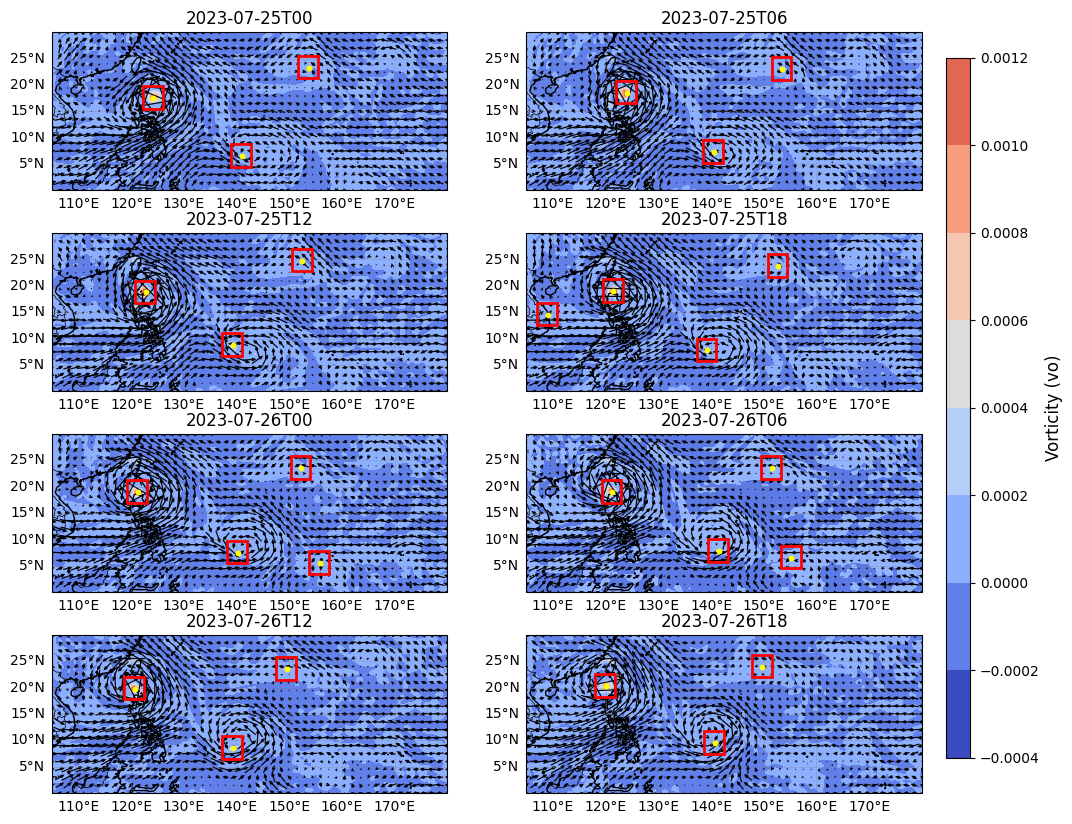

In [184]:
img_obj_smthtest = DrawImg(lons,lats,timeOfSpecific, (u_smth,v_smth, vo_smth) , save_img_pth= '此处未命名,因为现在没打算保存'    )                    
img_obj_smthtest.draw_img(get_dist_centerlist, test_list)  


In [12]:
print(f"{vo_smth.min():.5e}, {vo_smth.max():.5e}")  

-3.02243e-04, 1.32208e-03


In [11]:
print(f"{vo.min():.4e}, {vo.max():.4e}")  

-6.5743e-04, 1.6166e-03
